In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

,Extent,Date
0,668714.275,1979-01-01
1,566930.458,1979-02-01
2,688420.115,1979-03-01
3,859963.043,1979-04-01
4,1127120.160,1979-05-01
...,...,...
533,1134056.102,2023-06-01
534,1484824.377,2023-07-01
535,1671324.717,2023-08-01
536,1726376.097,2023-09-01


In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 28s 366ms/step - loss: 0.2107 - root_mean_squared_error: 0.4591 - val_loss: 0.1251 - val_root_mean_squared_error: 0.3537
Epoch 2/50
53/53 [==============================] - 18s 351ms/step - loss: 0.0685 - root_mean_squared_error: 0.2618 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2116
Epoch 3/50
53/53 [==============================] - 17s 335ms/step - loss: 0.0461 - root_mean_squared_error: 0.2147 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1809
Epoch 4/50
53/53 [==============================] - 19s 366ms/step - loss: 0.0341 - root_mean_squared_error: 0.1845 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 5/50
53/53 [==============================] - 20s 380ms/step - loss: 0.0236 - root_mean_squared_error: 0.1538 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 6/50
53/53 [==============================] - 3s 56ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.0121 - 

53/53 [==============================] - 18s 354ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645
Epoch 34/50
53/53 [==============================] - 3s 54ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 35/50
53/53 [==============================] - 3s 55ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 36/50
53/53 [==============================] - 3s 56ms/step - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 37/50
53/53 [==============================] - 5s 86ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 38/50
53/53 [==============================] - 19s 358ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0040 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

7.802408401171366 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

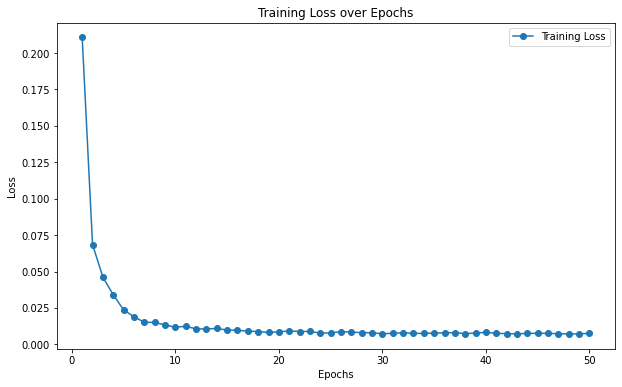

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

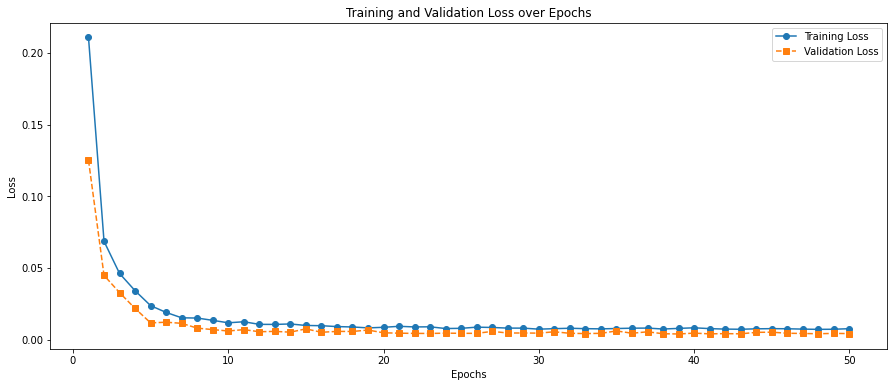

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 20ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07381891107235296
MAE : 0.05934562585758774


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.743964e+06,1890231.668
1,1.775711e+06,2203401.829
2,1.664881e+06,1960480.542
3,1.358939e+06,1264318.504
4,7.858612e+05,863206.294
5,3.520726e+05,635624.004
6,3.315855e+05,460009.672
7,4.710292e+05,610848.036
8,7.069344e+05,819257.445
9,1.010778e+06,1129627.707


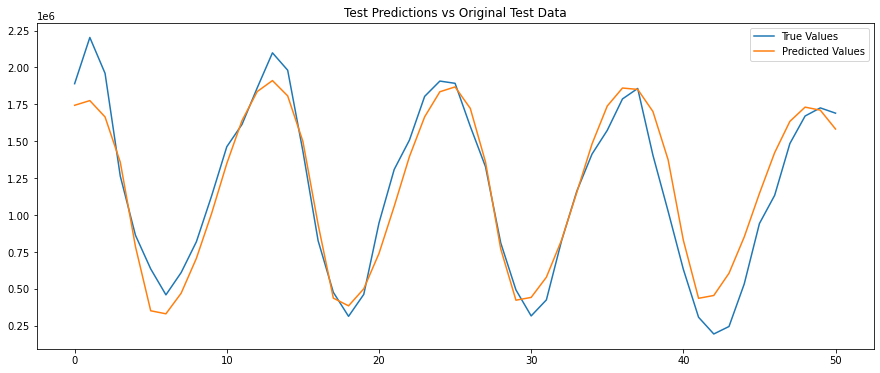

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 19ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

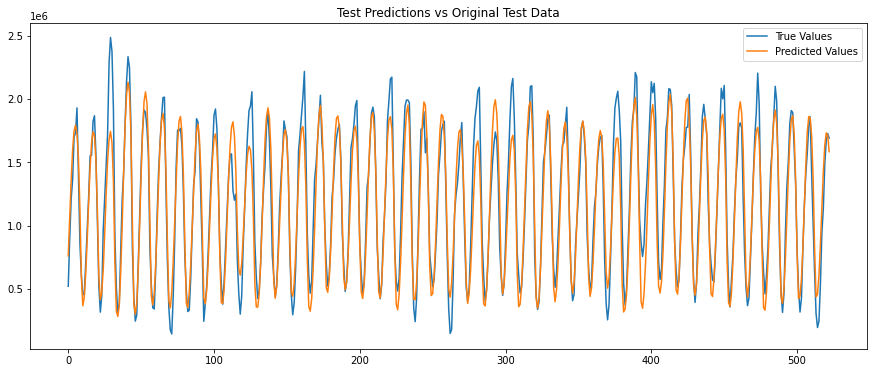

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()